In [135]:
#Save the below parameters to output.txt file
%logstart -o -r -t -q output.txt rotate

In [136]:
# General info
# using Adam Optimization
# Shuffling sources every epoch
# SCHUSTER's MARMOUSI MODEL

# General parameters
GPU=0      # which GPU to use
plot=True # Plot Intermediate results
sigma=10   # Initial model smoothness 
gpu_ids=[0,1]

# Inversion parameters
num_batches = 30
num_epochs = 5000

#gamma = 300  # Does not apply, Adam uses lr (learning rate) instead of gamma
# Adam learning rate
lr = 4

# Modeling parameters
freq = 25
dx = 10
nt = 800
dt = 0.0015
num_shots = 8
num_receivers_per_shot = 71

# receiver_spacing = # computed below from ny,dx and num_receivers_per_shot

# Close the ouput.txt file with saved parameters
%logstop 

In [137]:
# Need to restart runtime before this step
import time
import torch
import numpy as np
import scipy.ndimage
import scipy.io
import matplotlib.pyplot as plt
import deepwave
import os
import csv
import torch.nn as nn
from scipy.io import savemat
from skimage.transform import resize

(71, 71)

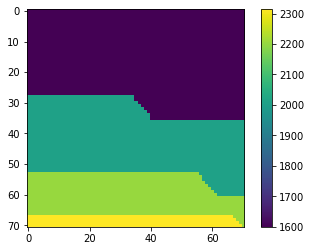

In [138]:
filename = '/disk/student/adhara/Fall2021/seismic-simulation-complex-media/generate_data/velocity/fault/velocity_150.npy'
mat = np.load(filename)
plt.imshow(mat.T)
plt.colorbar()
np.shape(mat)


In [139]:
np.min(mat[mat>1600])

2008.901

In [140]:
def plotVel(starting):
    
    #create figure
    fig = plt.figure(figsize=(15,7))
    
    rows = 5
    columns = 5
    
    for i in range(25):
        fig.add_subplot(rows,columns,i+1)
        kk=starting+i
        filename='/disk/student/adhara/Fall2021/seismic-simulation-complex-media/generate_data/velocity/fault/velocity_'+str(i)+'.npy'
        mat=np.load(filename)
        #mat_resize=resize(mat, (101,101))
        mat=mat.T
        print("min12:",np.min(mat))
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(mat)
        plt.axis('off')
        plt.tight_layout()
        

min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0


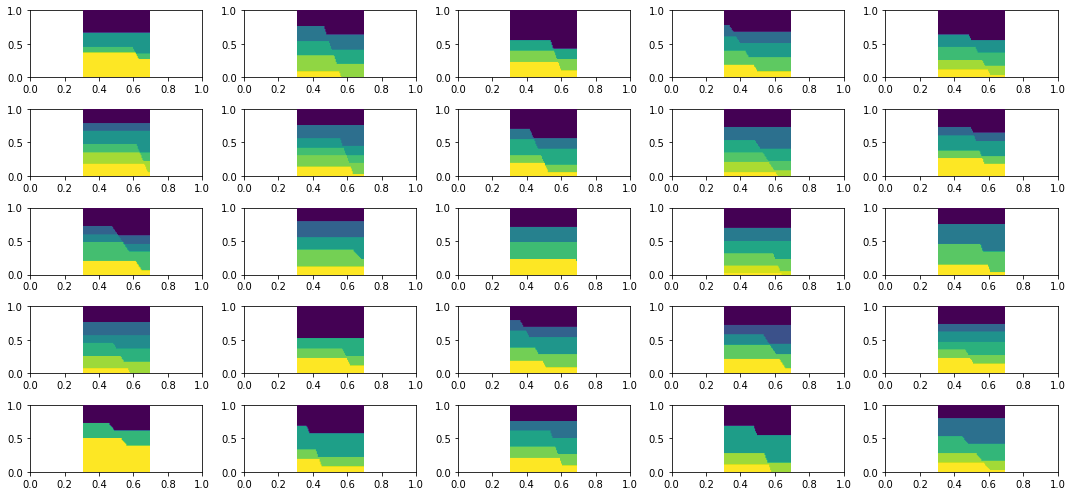

In [141]:
plotVel(1)

In [142]:
np.shape(mat)

(71, 71)

In [143]:
os.system('nvidia-smi')

0

min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0
min12: 1600.0


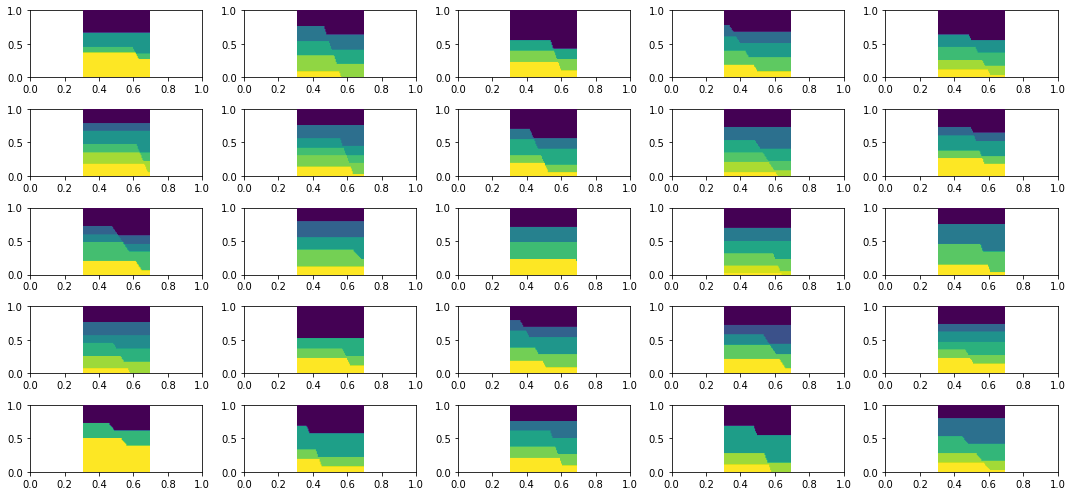

In [144]:
plotVel(800)

NameError: name 'newmat' is not defined

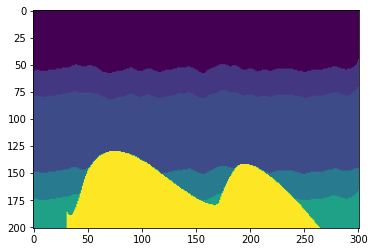

In [145]:
kk = 3
filename='/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/train_data/SimulateData/vmodel_train/vmodel'+str(kk)+'.mat'
mat=scipy.io.loadmat(filename)['vmodel']
np.shape(mat)
plt.imshow(mat)
mat_resize = np.resize(mat,(101,101))
plt.imshow(newmat)
type(mat)

In [146]:
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/train_data/SimulateData/georec_trainFault/')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/train_data/SimulateData/georec_trainFault/')

0

In [147]:
#plot=True
# Load the true model
min1 = []
max1 = []
for kk in range(1,500):
    #kk=2
    filename='/disk/student/adhara/Fall2021/seismic-simulation-complex-media/generate_data/velocity/fault/velocity_'+str(kk)+'.npy'
    mat=np.load(filename)
    mat=mat.T
    #mat=mat[:-1,:-1]
    #mat = np.loadtxt('marmhard2.dat')
    #mat = np.pad(mat,((10,0),(0,0)),'edge') #RB add some water layer
    #RB Get model size
    ny = np.size(mat,1);
    nz = np.size(mat,0);
    #RB compute true model mean value and width for future model normalization
    max=np.max(mat)
    min=np.min(mat)
    med=(max+min)/2.
    wid=(max-min)/2.

    print('vmin=',min,'vmax=',max,'vmed=',med,'vwidth=',wid)
    torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
    GPU_string='cuda:'+str(GPU)
    device = torch.device(GPU_string)
    num_dims = 2
    #num_shots = 32
    num_sources_per_shot = 1
    #num_receivers_per_shot = 200

    #RB source_spacing = 25.0
    #RB receiver_spacing = 10.0
    source_spacing = ny * dx / num_shots
    receiver_spacing = ny * dx / num_receivers_per_shot
    print('ny=',ny,'nz=',nz,'nt=',nt,'dx=',dx,'freq=',freq)
    print('shots=',num_shots,'recs/shot=',num_receivers_per_shot, \
          'ds=',source_spacing,'dr=',receiver_spacing)
    
    # Create arrays containing the source and receiver locations
    # x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
    # x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
    x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
    x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing
    #x_s[:, 0, 0] = 100. #RB Set source depth

    x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
    x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
    x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

    #RB Shuffle shot coordinates
    ###idx = torch.randperm(num_shots)
    ###x_s = x_s.view(-1,2)[idx].view(x_s.size())

    #RB Set Receiver depth
    #x_r[0, :, 0] = 100.
    #x_r[:, :, 0] = x_r[0, :, 0].repeat(num_shots, 1)

    # Create true source amplitudes [nt, num_shots, num_sources_per_shot]
    # I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
    # can use whatever Tensor you want as the source amplitude.
    source_amplitudes_true = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                              .reshape(-1, 1, 1)
                              .repeat(1, num_shots, num_sources_per_shot))
    
    model_true = torch.Tensor(mat) # Convert to a PyTorch Tensor
    prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
    receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                    x_s.to(device),
                                    x_r.to(device), dt).cpu()
    
    vel=np.squeeze(mat)
    seis=np.squeeze(receiver_amplitudes_all.cpu().detach().numpy())
    seis = seis.swapaxes(1,2)
    mdic = {"Rec":seis}
    
    print(np.shape(seis))
    file1 = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/train_data/SimulateData/georec_trainFault/georec'+str(kk)+'.mat','wb')
    savemat(file1, mdic)
    file1.close()
    #file1 = open('/glb/data/eptr_am_2/Arnab/seismogram/trainA/'+str(kk)+'.npy','wb')
    #np.save(file1,seis)
    #file1.close()
    
    min1 = np.append(min1,np.min(vel))
    max1 = np.append(max1,np.max(vel))

vmin= 1600.0 vmax= 2377.0088 vmed= 1988.50439453125 vwidth= 388.50439453125
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2035.7701 vmed= 1817.885009765625 vwidth= 217.88507080078125
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2419.302 vmed= 2009.6510009765625 vwidth= 409.6510009765625
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2476.0002 vmed= 2038.0001220703125 vwidth= 438.0001220703125
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2800.0 vmed= 2200.0 vwidth= 600.0
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2131.8706 vmed= 1865.935302734375 vwidth= 265.935302734375
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71,

(800, 71, 8)
vmin= 1600.0 vmax= 2126.1821 vmed= 1863.091064453125 vwidth= 263.091064453125
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2800.0 vmed= 2200.0 vwidth= 600.0
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2315.5154 vmed= 1957.7576904296875 vwidth= 357.7576904296875
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2317.4116 vmed= 1958.705810546875 vwidth= 358.705810546875
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2168.8691 vmed= 1884.4345703125 vwidth= 284.4345703125
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2430.8445 vmed= 2015.4222412109375 vwidth= 415.4222412109375
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0

(800, 71, 8)
vmin= 1600.0 vmax= 2800.0 vmed= 2200.0 vwidth= 600.0
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2298.509 vmed= 1949.2545166015625 vwidth= 349.2545166015625
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 1963.1031 vmed= 1781.551513671875 vwidth= 181.55157470703125
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2506.4185 vmed= 2053.209228515625 vwidth= 453.209228515625
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2209.8164 vmed= 1904.908203125 vwidth= 304.908203125
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2148.5454 vmed= 1874.272705078125 vwidth= 274.272705078125
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(8

(800, 71, 8)
vmin= 1600.0 vmax= 2191.779 vmed= 1895.8895263671875 vwidth= 295.8895263671875
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2428.2366 vmed= 2014.1182861328125 vwidth= 414.1182861328125
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2342.4421 vmed= 1971.2210693359375 vwidth= 371.2210693359375
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 1993.8026 vmed= 1796.9013671875 vwidth= 196.90130615234375
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2358.3816 vmed= 1979.1907958984375 vwidth= 379.1907958984375
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2108.0588 vmed= 1854.0294189453125 vwidth= 254.0294189453125
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 

(800, 71, 8)
vmin= 1600.0 vmax= 2132.6921 vmed= 1866.3460693359375 vwidth= 266.3460693359375
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2079.4465 vmed= 1839.7232666015625 vwidth= 239.7232666015625
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2800.0 vmed= 2200.0 vwidth= 600.0
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2359.6116 vmed= 1979.8057861328125 vwidth= 379.8057861328125
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2669.9238 vmed= 2134.9619140625 vwidth= 534.9619140625
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2241.8677 vmed= 1920.933837890625 vwidth= 320.933837890625
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10

(800, 71, 8)
vmin= 1600.0 vmax= 2193.6052 vmed= 1896.8026123046875 vwidth= 296.8026123046875
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2501.9187 vmed= 2050.95947265625 vwidth= 450.9593505859375
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2641.0813 vmed= 2120.54052734375 vwidth= 520.5406494140625
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2417.1897 vmed= 2008.5948486328125 vwidth= 408.5948486328125
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2300.2317 vmed= 1950.1158447265625 vwidth= 350.1158447265625
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2233.9766 vmed= 1916.98828125 vwidth= 316.98828125
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot

vmin= 1600.0 vmax= 2073.4172 vmed= 1836.7086181640625 vwidth= 236.7086181640625
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2800.0 vmed= 2200.0 vwidth= 600.0
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2447.8262 vmed= 2023.9130859375 vwidth= 423.9130859375
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2263.8218 vmed= 1931.910888671875 vwidth= 331.910888671875
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2492.0945 vmed= 2046.0472412109375 vwidth= 446.0472412109375
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2386.214 vmed= 1993.1070556640625 vwidth= 393.1070556640625
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8

vmin= 1600.0 vmax= 2332.7812 vmed= 1966.390625 vwidth= 366.390625
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2025.8163 vmed= 1812.908203125 vwidth= 212.90814208984375
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2170.5037 vmed= 1885.2518310546875 vwidth= 285.2518310546875
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2393.7 vmed= 1996.8499755859375 vwidth= 396.8499755859375
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2086.1487 vmed= 1843.0743408203125 vwidth= 243.0743408203125
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2295.2905 vmed= 1947.645263671875 vwidth= 347.645263671875
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10

vmin= 1600.0 vmax= 2800.0 vmed= 2200.0 vwidth= 600.0
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2525.8745 vmed= 2062.937255859375 vwidth= 462.937255859375
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2068.8555 vmed= 1834.427734375 vwidth= 234.427734375
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2573.1936 vmed= 2086.5966796875 vwidth= 486.5968017578125
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2402.1592 vmed= 2001.07958984375 vwidth= 401.07958984375
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2245.9478 vmed= 1922.973876953125 vwidth= 322.973876953125
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 16

(800, 71, 8)
vmin= 1600.0 vmax= 2020.4492 vmed= 1810.224609375 vwidth= 210.224609375
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2254.8647 vmed= 1927.432373046875 vwidth= 327.432373046875
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2253.1777 vmed= 1926.5888671875 vwidth= 326.5888671875
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2331.1106 vmed= 1965.5552978515625 vwidth= 365.5552978515625
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2800.0 vmed= 2200.0 vwidth= 600.0
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71, 8)
vmin= 1600.0 vmax= 2616.8552 vmed= 2108.427734375 vwidth= 508.4276123046875
ny= 71 nz= 71 nt= 800 dx= 10 freq= 25
shots= 8 recs/shot= 71 ds= 88.75 dr= 10.0
(800, 71,

In [148]:
np.shape(seis)

(800, 71, 8)

Text(0.5, 1.0, 'Model seismogram')

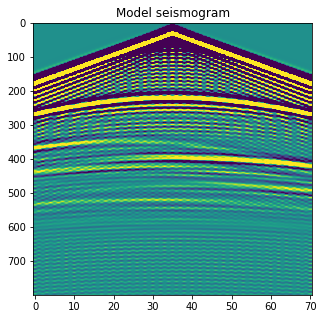

In [157]:
plt.figure(figsize=(5, 5))
plt.imshow(seis[:,:,4],vmin=-.05,vmax=.05, aspect='auto')
    
plt.title('Model seismogram')

In [27]:
plt.imshow(A)

NameError: name 'A' is not defined

In [28]:
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/test_data/SimulateData/georec_test/')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/test_data/SimulateData/georec_test/')

0

In [129]:
#plot=True
# Load the true model
min1 = []
max1 = []
for kk in range(100,150):
    #kk=2
    filename='/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/test_data/SimulateData/vmodel_test/vmodel'+str(kk)+'.mat'
    #filename='/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/train_data/SimulateData/vmodel_train/vmodel'+str(kk)+'.mat'
    mat=scipy.io.loadmat(filename)['vmodel']
    mat=resize(mat,(101,101))
    #mat=mat[:-1,:-1]
    #mat = np.loadtxt('marmhard2.dat')
    #mat = np.pad(mat,((10,0),(0,0)),'edge') #RB add some water layer
    #RB Get model size
    ny = np.size(mat,1);
    nz = np.size(mat,0);
    #RB compute true model mean value and width for future model normalization
    max=np.max(mat)
    min=np.min(mat)
    med=(max+min)/2.
    wid=(max-min)/2.

    print('vmin=',min,'vmax=',max,'vmed=',med,'vwidth=',wid)
    torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
    GPU_string='cuda:'+str(GPU)
    device = torch.device(GPU_string)
    num_dims = 2
    #num_shots = 32
    num_sources_per_shot = 1
    #num_receivers_per_shot = 200

    #RB source_spacing = 25.0
    #RB receiver_spacing = 10.0
    source_spacing = ny * dx / num_shots
    receiver_spacing = ny * dx / num_receivers_per_shot
    print('ny=',ny,'nz=',nz,'nt=',nt,'dx=',dx,'freq=',freq)
    print('shots=',num_shots,'recs/shot=',num_receivers_per_shot, \
          'ds=',source_spacing,'dr=',receiver_spacing)
    
    # Create arrays containing the source and receiver locations
    # x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
    # x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
    x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
    x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing
    #x_s[:, 0, 0] = 100. #RB Set source depth

    x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
    x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
    x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

    #RB Shuffle shot coordinates
    ###idx = torch.randperm(num_shots)
    ###x_s = x_s.view(-1,2)[idx].view(x_s.size())

    #RB Set Receiver depth
    #x_r[0, :, 0] = 100.
    #x_r[:, :, 0] = x_r[0, :, 0].repeat(num_shots, 1)

    # Create true source amplitudes [nt, num_shots, num_sources_per_shot]
    # I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
    # can use whatever Tensor you want as the source amplitude.
    source_amplitudes_true = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                              .reshape(-1, 1, 1)
                              .repeat(1, num_shots, num_sources_per_shot))
    
    model_true = torch.Tensor(mat) # Convert to a PyTorch Tensor
    prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
    receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                    x_s.to(device),
                                    x_r.to(device), dt).cpu()
    
    vel=np.squeeze(mat)
    seis=np.squeeze(receiver_amplitudes_all.cpu().detach().numpy())
    seis = seis.swapaxes(1,2)
    mdic = {"Rec":seis}
    
    print(np.shape(seis))
    file1 = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/test_data/SimulateData/georec_test/georec'+str(kk)+'.mat','wb')
    savemat(file1, mdic)
    file1.close()
    #file1 = open('/glb/data/eptr_am_2/Arnab/seismogram/trainA/'+str(kk)+'.npy','wb')
    #np.save(file1,seis)
    #file1.close()
    
    min1 = np.append(min1,np.min(vel))
    max1 = np.append(max1,np.max(vel))

FileNotFoundError: [Errno 2] No such file or directory: '/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/test_data/SimulateData/vmodel_test/vmodel100.mat'

In [ ]:
print(np.min(min1))

In [ ]:
print(np.max(max1))

In [ ]:
np.max(VelK)

In [ ]:
f1 = np.load('/glb/data/eptr_am_2/Arnab/seismogram/trainB/'+str(1)+'.npy')
f1 = np.load('/glb/data/eptr_am_2/Arnab/seismogram/trainB/'+str(1)+'.npy')
np.shape(f1)

In [ ]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat,vmin=min,vmax=max, aspect=1)
    plt.title('True model')
    plt.colorbar()

In [ ]:
# Specify which GPU to use (in multi GPU machines)
torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
GPU_string='cuda:'+str(GPU)
device = torch.device(GPU_string)

In [ ]:
# Set parameters
##freq = 14
##dx = 10
##dt = 0.001

#RB nt = int(2 / dt) # 2s
#nt = int(0.9 * int(np.sqrt((nz*dx)**2 + (ny*dx)**2) / 2000 / dt))
#nt =       3 * int(np.sqrt((nz*dx)**2 + (ny*dx)**2) / 2000 / dt)
##nt = 4001

num_dims = 2
#num_shots = 32
num_sources_per_shot = 1
#num_receivers_per_shot = 200

#RB source_spacing = 25.0
#RB receiver_spacing = 10.0
source_spacing = ny * dx / num_shots
receiver_spacing = ny * dx / num_receivers_per_shot
#receiver_spacing = 8.

print('ny=',ny,'nz=',nz,'nt=',nt,'dx=',dx,'freq=',freq)
print('shots=',num_shots,'recs/shot=',num_receivers_per_shot, \
      'ds=',source_spacing,'dr=',receiver_spacing)


In [ ]:
# Create arrays containing the source and receiver locations
# x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
# x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing
#x_s[:, 0, 0] = 100. #RB Set source depth

x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

#RB Shuffle shot coordinates
###idx = torch.randperm(num_shots)
###x_s = x_s.view(-1,2)[idx].view(x_s.size())

#RB Set Receiver depth
#x_r[0, :, 0] = 100.
#x_r[:, :, 0] = x_r[0, :, 0].repeat(num_shots, 1)

# Create true source amplitudes [nt, num_shots, num_sources_per_shot]
# I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
# can use whatever Tensor you want as the source amplitude.
source_amplitudes_true = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))

In [ ]:
model_true = torch.Tensor(mat) # Convert to a PyTorch Tensor
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

In [ ]:
receiver_amplitudes_all.shape

In [ ]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_all[:,2].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
    plt.title('Model seismogram')

In [ ]:
vel=mat
seis=receiver_amplitudes_all.cpu().detach().numpy()
file1 = open('/glb/data/eptr_am_2/Arnab/seismogram/trainvel/'+str(kk)+'.npy','wb')
np.save(file1,vel)
file1.close()
file1 = open('/glb/data/eptr_am_2/Arnab/seismogram/trainseis/'+str(kk)+'.npy','wb')
np.save(file1,seis)
file1.close()

In [ ]:
np.shape(seis)

In [ ]:
np.shape(vel)